# Supernovae II

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the kernels submodule of sklearn.gaussian_process
- Hint. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.
Note. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of data-driven predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a parametric fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module and the redshift
- Assuming a flat Universe, we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$.
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$? Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m$=1) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.

- Think about the pdf of these data in z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

In [1]:
from astroML.datasets import generate_mu_z
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from astropy.cosmology import LambdaCDM, Planck18
import emcee
import corner
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import h5py
import dynesty
from dynesty import NestedSampler
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import scipy.stats

Text(0.5, 1.0, 'Supernovae dataset')

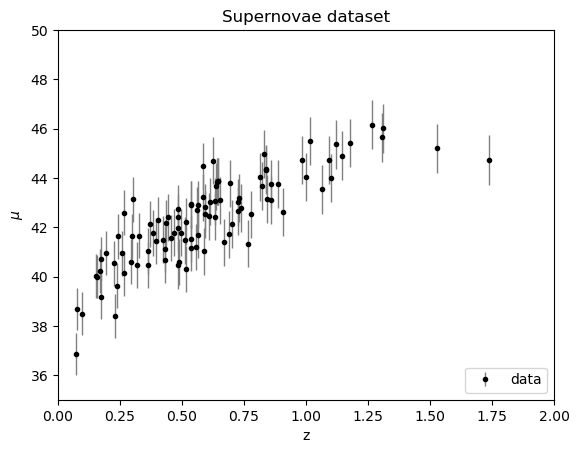

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
z_sample_r = z_sample[:, np.newaxis]
mu_sample_r = mu_sample[:, np.newaxis]

Xgrid = np.linspace(0, 2.0, 100)
Xpoint=Xgrid[:, np.newaxis]

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Supernovae dataset')

## Gaussian Process Regression (GPR)

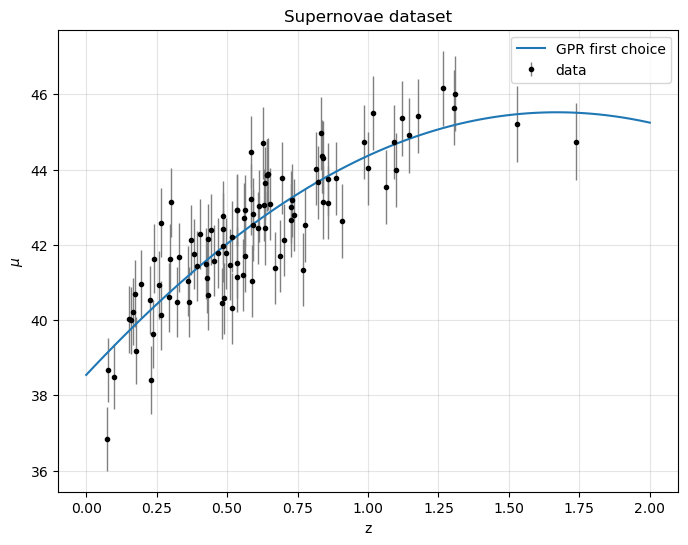

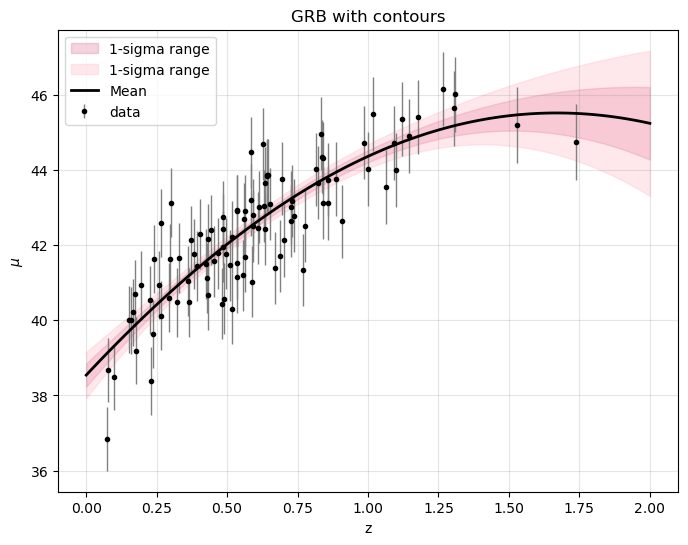

In [3]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel = kernel, alpha=dmu ** 2) #length_scale: how rapidly the correlation bt points decreases with increase of the distance bt them
gp.fit(z_sample_r, mu_sample_r)
y_pred, dy_pred = gp.predict(Xpoint, return_std=True)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.grid(c='grey', alpha = 0.2)
ax.set_title('Supernovae dataset')
ax.set_xlabel('z')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
ax.plot(Xgrid, y_pred, label ='GPR first choice')
ax.set_ylabel('$\mu$')
ax.legend()

fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.gca()
ax2.grid(c='grey', alpha = 0.2)
ax2.set_title('GRB with contours')
ax2.set_xlabel('z')
ax2.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
ax2.fill_between(Xgrid.flatten(), y_pred - dy_pred, y_pred + dy_pred, color='palevioletred', alpha=0.3, label='1-sigma range')
ax2.fill_between(Xgrid.flatten(), y_pred - 2*dy_pred, y_pred + 2*dy_pred, color='lightpink', alpha=0.3, label='1-sigma range')
ax2.set_ylabel('$\mu$')
ax2.plot(Xgrid, y_pred, 'k-', label='Mean', lw=2)
ax2.legend()


We should perform cross validation to find the best parameters for the fit 

## Fit

### MCMC: $H_0$ and $\Omega_m$

In [4]:
def LCDM(z, theta):
    H_0, Omega_m = theta
    cosmo_tmp = LambdaCDM(H0=H_0, Om0=Omega_m, Ode0=1-Omega_m)
    mu_model = cosmo_tmp.distmod(z).value
    return  mu_model
    
def LogLikelihood(x, theta, sigma_y, y):
    H_0, Omega_m = theta
    model_values=[]
    if Omega_m < 0:
        return -np.inf 
    else:
        model_values = [LCDM(i, theta) for i in x]
        return -0.5 * np.sum((y-model_values)**2 / sigma_y**2 ) 

def LogPrior(theta):     # Step prior
    H_0, Omega_m = theta
    if 50 < H_0 < 100 and 0.1 < Omega_m < 1:
        return 0.0
    return -np.inf
                   
def LogPosterior(theta, x, sigma_y, y):
    return LogLikelihood(x, theta, sigma_y, y) + LogPrior(theta)

C:\Users\ISAFA\anaconda3\Lib\site-packages\astropy\cosmology\flrw\base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


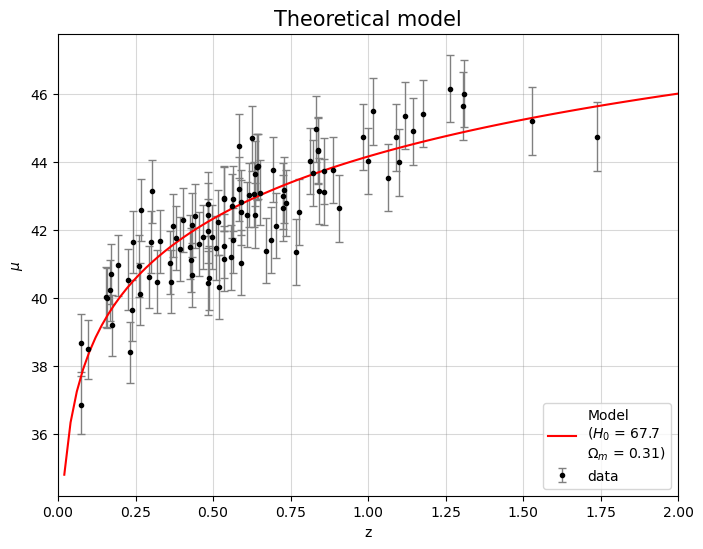

In [5]:
Omega_theo = Planck18.Om0
H0_theo = Planck18.H0.value 
theta =[H0_theo, Omega_theo]
mu_theo_model = LCDM(Xgrid, theta)

plt.figure(figsize=(8, 6))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')

plt.plot(Xgrid, mu_theo_model, ls = '-', color = 'red', lw = 1.5, label = 'Model\n($H_0$ = %.1f\n$\\Omega_m$ = %.2f)' % (H0_theo, Omega_theo))

plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.title('Theoretical model', fontsize = 15)
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)

plt.show()

In [22]:
#MCMC with emcee
ndim = 2  #Number of parameters in the model
nwalkers = 10  #Number of MCMC walkers
nsteps = 10000  #Number of MCMC steps to take **for each walker**
theta = [68, 0.3] 

#Initilize parameters 
starting_guesses = theta + np.random.normal(loc=0, scale=0.1, size=(nwalkers, ndim))

backend = emcee.backends.HDFBackend("MCMC_LCDM.h5")
backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[z_sample, dmu, mu_sample], backend=backend)
sampler.run_mcmc(starting_guesses, nsteps, progress = True, store = True)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:52:55<00:00,  1.48it/s]


State([[61.1077413   0.48662077]
 [60.99521856  0.82797843]
 [70.1604304   0.37860859]
 [68.99241215  0.19878611]
 [73.04854741  0.27038355]
 [67.45710206  0.30021005]
 [76.09202167  0.11408177]
 [62.87905434  0.42413737]
 [60.78088469  0.74990792]
 [68.33450885  0.39763523]], log_prob=[-47.66952296 -46.95784122 -46.71960696 -47.1785417  -46.75833616
 -46.66306751 -46.79448578 -47.32674401 -46.74837051 -46.45824246], blobs=None, random_state=('MT19937', array([2867012292, 3807436421,  683494899, 3929164197, 4030487478,
       1913972509, 1822686206,  931977613,  265866439, 3657176870,
       2645423878, 2628681251, 2705312999, 2938700776, 3271018020,
        564811283, 4139563685, 3539351994,  347935133, 3071240717,
       1592640507, 3249706344, 3074762809, 2429931592, 1957044680,
        759691744, 1504964448, 2877471507,  354848682, 1028810293,
        495308432, 3114652847, 1301972988,  679943617, 3080852632,
       2322569924,  870046170, 1895865308, 3806613307, 1162113719,
      

[38.16886193 38.39881203]


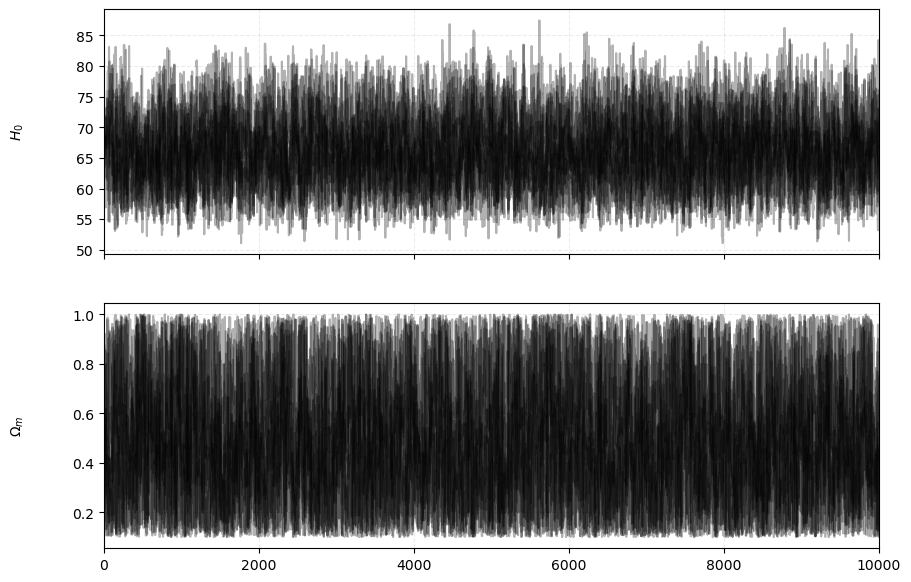

In [45]:
reader = emcee.backends.HDFBackend("MCMC_LCDM.h5")
samples_chain =  reader.get_chain()
labels = ["$H_0$","$\Omega_m$"]

fig2, ax2 = plt.subplots(2, figsize=(10, 7), sharex=True)
for i in range(2):
    ax2[i].plot(samples_chain[:, :, i], "k", alpha=0.3)
    ax2[i].set_xlim(0, len(samples_chain))
    ax2[i].set_ylabel(labels[i])
    ax2[i].yaxis.set_label_coords(-0.1, 0.5)
    ax2[i].grid(c='grey', alpha=0.15, ls='--')

tau = reader.get_autocorr_time()
print(tau)

#Set the burn-in 
burn = 3*int(max(tau))

#We need a 2D array to do the corner plot 
flat_samples = reader.get_chain(discard=burn, thin=int(max(tau)), flat=True)

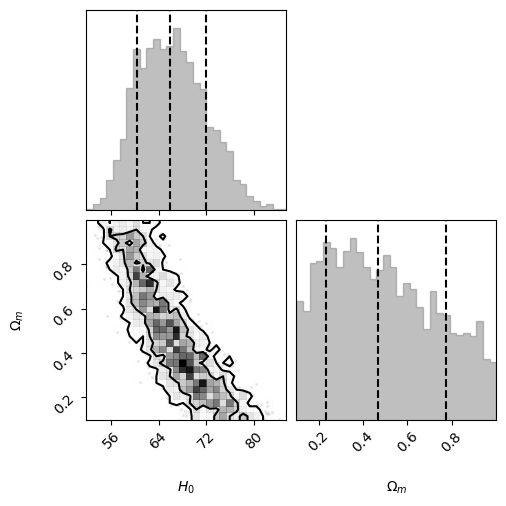

In [63]:
#Corner plot
fig = corner.corner(flat_samples, labels=labels, plot_datapoints = True, levels = [0.68,0.95], 
                    quantiles =[0.16, 0.5, 0.84], bins = 30, 
                    hist_kwargs={"fill": True, "color": "grey", "alpha": 0.5}, use_math_text=True)


We extract 100 random set of parameters found throught MCMC and we see how they fit the data.

In [64]:
random_samples= np.array(flat_samples[np.random.choice(len(flat_samples),size=100)])

fit = []

for j in range(len(random_samples)):
    model_values=[]
    for i in Xgrid:
        model_values.append(LCDM(i,random_samples[j]))
    fit.append(model_values)

C:\Users\ISAFA\anaconda3\Lib\site-packages\astropy\cosmology\flrw\base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


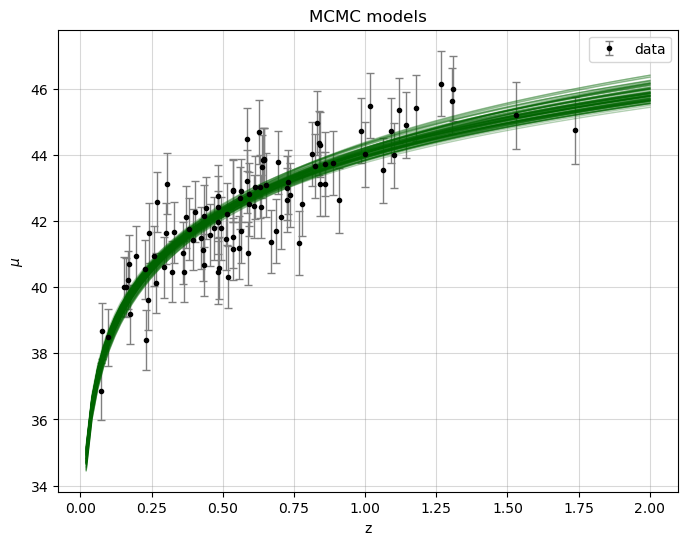

In [65]:
plt.figure(figsize=(8, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
for i in fit: 
 plt.plot(Xgrid, i, lw = 1, alpha = 0.3, color='darkgreen')
    
plt.title('MCMC models')
plt.grid(alpha=0.3, c = 'grey')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend()

The models extracted fit the data well but the parameters have great uncertainties.

### Non-linear least squares fit

The fit gives us these parameters: H_0 = 68.52, Omega_m = 0.34


C:\Users\ISAFA\anaconda3\Lib\site-packages\astropy\cosmology\flrw\base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


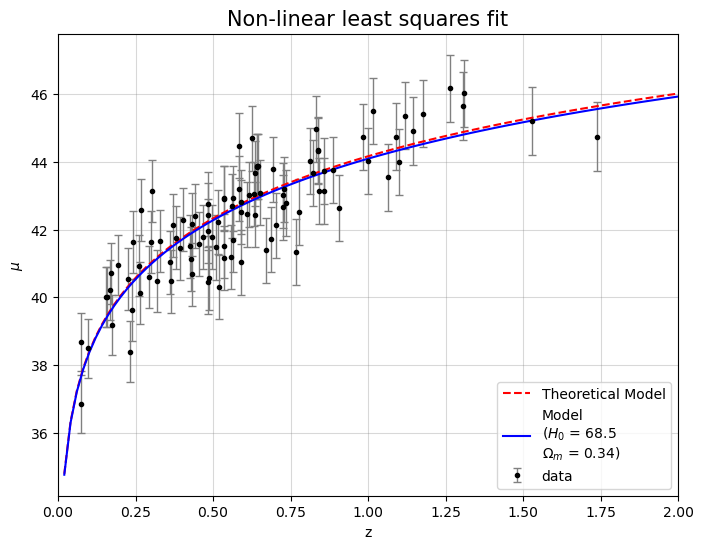

The covariance matrix is: [[59.05569438 -2.06268549]
 [-2.06268549  0.08483691]]
Covariance between H_0 e Omega_m: -2.06


In [47]:
def LCDM1(z, H_0, Omega_m):
    cosmo_tmp = LambdaCDM(H0 = H_0, Om0 = Omega_m, Ode0=1-Omega_m)
    mu_model = cosmo_tmp.distmod(z).value
    return  mu_model
params, covariance = curve_fit(LCDM1, z_sample, mu_sample, sigma = dmu, absolute_sigma = True, bounds=([0, 0], [100, 1]))

H_opt, Omega_opt = params
print(r'The fit gives us these parameters: H_0 = %.2f, Omega_m = %.2f' % (H_opt, Omega_opt))

#Prediction
mu_fit = LCDM1(Xgrid, H_opt, Omega_opt)

plt.figure(figsize=(8, 6))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
plt.plot(Xgrid, mu_theo_model, ls = '--', color = 'red', lw = 1.5, label = 'Theoretical Model')
plt.plot(Xgrid, mu_fit, ls = '-', color = 'blue', lw = 1.5, label = 'Model\n($H_0$ = %.1f\n$\\Omega_m$ = %.2f)' % (H_opt, Omega_opt))

plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.title('Non-linear least squares fit', fontsize = 15)
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)

plt.show()

cov_H0_Omega_m = covariance[0, 1]
print('The covariance matrix is:', covariance)
print(r'Covariance between H_0 e Omega_m: %.2f'% cov_H0_Omega_m)

The covariance is negative so this means that the two parameters are inversely correlated.

## Model selection 

### Evaluation of the maximum loglikelihood for the two models

In [6]:
#Define the function for the new model 
def model_matter(z, H0):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=1, Ode0 = 0)
    mu_model_matter = cosmo_tmp.distmod(z).value
    return  mu_model_matter

def LogLikelihood_matter(x, H0, sigma_y, y):
    model_values=[]
    Omega = 1
    H0 = float(H0)
    model_values = [model_matter(i, H0) for i in x]
    return -0.5 * np.sum((y-model_values)**2 / sigma_y**2 )  
    
def LogPrior_matter(H_0):     # Step prior
    if 50 < H_0 < 100:
        return 0.0
    return -np.inf

#Rewrite the function for the loglike of LCDM
def LogLikelihood(x, theta, sigma_y, y):
    H_0, Omega_m = theta
    model_values=[]
    if Omega_m < 0:
        return -np.inf 
    else:
        model_values = [LCDM(i, theta) for i in x]
        return -0.5 * np.sum((y-model_values)**2 / sigma_y**2 ) 

#Define the function for the aic
def AIC(loglike, k, N): #k=number of model parameter, N=number of data points
    return -2*loglike+2*k+((2*k*(k+1))/(N-k-1))

The fit gives us these parameters: H_0 = 57.61


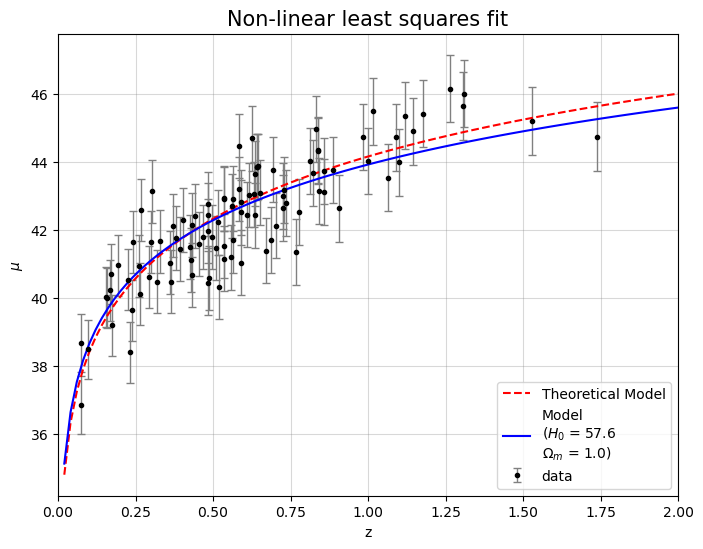

In [7]:
#Fit the second model
param, covariance = curve_fit(model_matter, z_sample, mu_sample, sigma = dmu, absolute_sigma = True, bounds=([1, 100]))

H_opt2 = param[0]
print(r'The fit gives us these parameters: H_0 = %.2f' % H_opt2)

#Prediction
mu_fit = model_matter(Xgrid, H_opt2)

plt.figure(figsize=(8, 6))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
plt.plot(Xgrid, mu_theo_model, ls = '--', color = 'red', lw = 1.5, label = 'Theoretical Model')
plt.plot(Xgrid, mu_fit, ls = '-', color = 'blue', lw = 1.5, label = 'Model\n($H_0$ = %.1f\n$\\Omega_m$ = %.1f)' % (H_opt2, 1))

plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.title('Non-linear least squares fit', fontsize = 15)
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)

plt.show()

In [69]:
theta_LCDM = [H_opt, Omega_opt]
loglike_LCDM = LogLikelihood(z_sample, theta_LCDM, dmu, mu_sample)
loglike_matter = LogLikelihood_matter(z_sample, H_opt2, dmu, mu_sample)
AIC_LCDM = AIC(loglike_LCDM, 2, len(z_sample))
AIC_matter = AIC(loglike_matter, 1, len(z_sample))

print('The maximum loglikelihood for the \u039BCDM model is:', loglike_LCDM)
print('The maximum loglikelihood for the Matter model is:', loglike_matter)
print('The AIC for the \u039BCDM model is:', AIC_LCDM)
print('The AIC for the Matter model is:', AIC_matter)

The maximum loglikelihood for the ΛCDM model is: -46.38509371938883
The maximum loglikelihood for the Matter model is: -47.10216509708751
The AIC for the ΛCDM model is: 96.89389877898384
The AIC for the Matter model is: 96.24514652070563


The best model comparing the maximum loglikelihood is the $\Lambda$CDM model even if the difference is quiete small, but if we look to the AIC the best seems the model in which $\Omega_m$=1. 

### Bayesian factor 

In [15]:
#Define again the function that we need
def LCDM(z, theta):
    H_0, Omega_m = theta
    cosmo_tmp = LambdaCDM(H0=H_0, Om0=Omega_m, Ode0=1-Omega_m)
    mu_model = cosmo_tmp.distmod(z).value
    return  mu_model

def model_matter(z, H_0):
    cosmo_tmp = LambdaCDM(H0=H_0, Om0=1, Ode0 = 0)
    mu_model_matter = cosmo_tmp.distmod(z).value
    return  mu_model_matter
    
def LogLikelihood(theta, x, sigma_y, y):
    H_0, Omega_m = theta
    model_values=[]
    if Omega_m < 0:
        return -np.inf 
    else:
        model_values = [LCDM(i, theta) for i in x]
        return -0.5 * np.sum((y-model_values)**2 / sigma_y**2 ) 

def LogLikelihood_matter(param, z, sigma_mu, mu):
    H_0 = param[0]
    model_values =[]   
    model_values = [model_matter(i, H_0) for i in z]
    return -0.5 * np.sum((mu-model_values)**2 / sigma_mu**2 ) 
    
def Prior(u):
    H0_min, H0_max = 50, 100
    Om_min, Om_max = 0.1, 1
    H0 = scipy.stats.uniform(loc=H0_min,scale=H0_max-H0_min).ppf(u[0])
    Om = scipy.stats.uniform(loc=Om_min,scale=Om_max-Om_min).ppf(u[1])
    return H0, Om
    

def Prior_matter(u):
    H0_min, H0_max = 50, 100
    H_0 = scipy.stats.uniform(loc=H0_min,scale=H0_max-H0_min).ppf(u[0])
    return np.array([H_0])

1487it [12:14,  2.03it/s, +500 | bound: 0 | nc: 1 | ncall: 10473 | eff(%): 19.924 | loglstar:   -inf < -46.385 <    inf | logz: -48.500 +/-  0.038 | dlogz:  0.001 >  0.509]


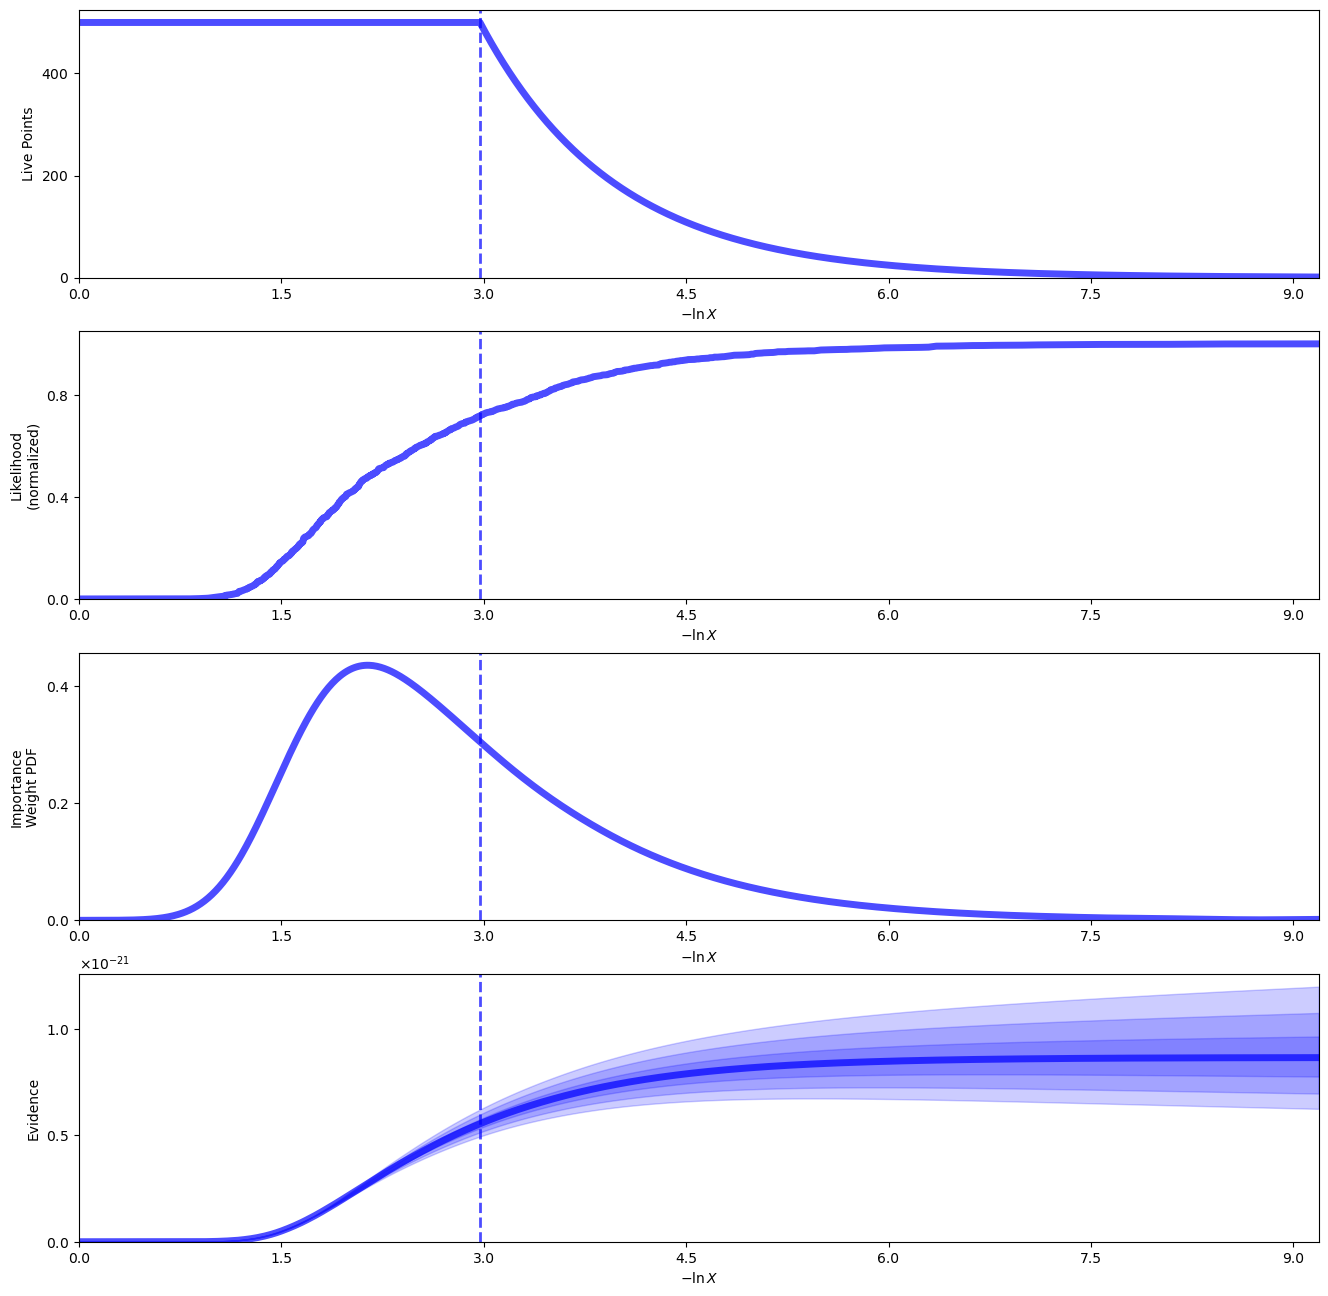

In [22]:
#Nested sampling for LCDM
ndim=2
theta=[68, 0.3]
nest_sampler = dynesty.NestedSampler(LogLikelihood, Prior, ndim, logl_args=[z_sample, dmu, mu_sample])
nest_sampler.run_nested()
results_LCDM = nest_sampler.results

# Plot results
rfig, raxes = dyplot.runplot(results_LCDM)

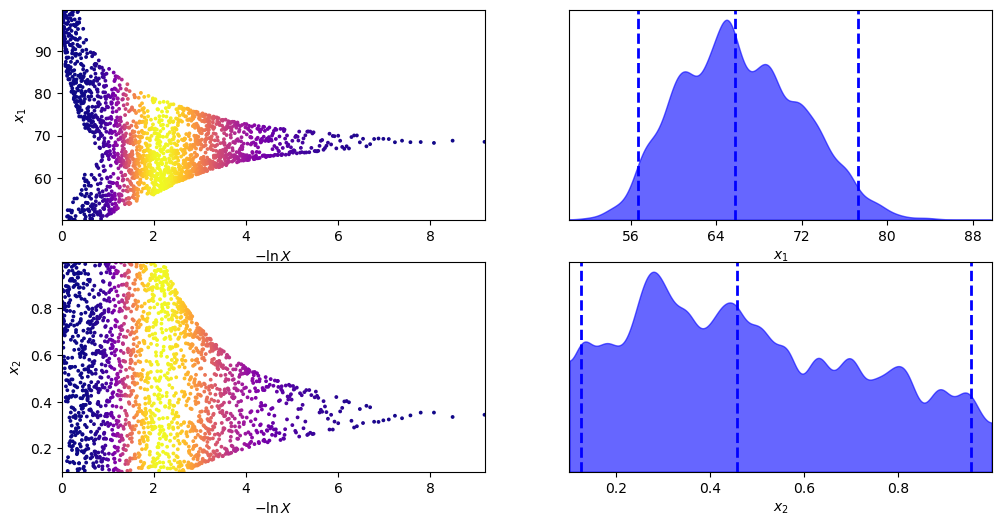

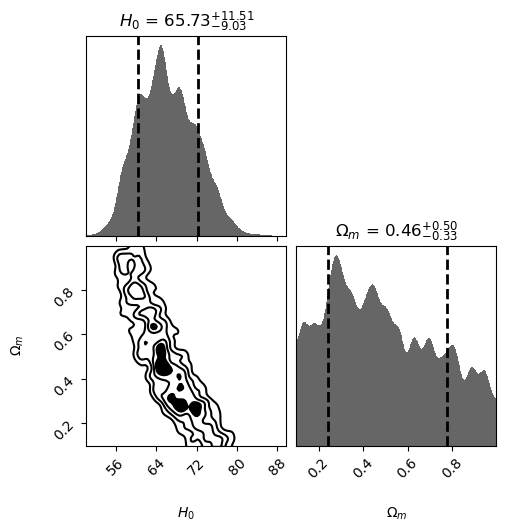

In [91]:
tfig, taxes = dyplot.traceplot(results_LCDM)

fig, axes = dyplot.cornerplot(results_LCDM, show_titles=True, quantiles=[0.16, 0.84], labels=labels)
plt.show()

In [16]:
#Nested sampling for Omega matter=1
ndim_matter=1
sampler_matter = dynesty.NestedSampler(LogLikelihood_matter, Prior_matter, ndim_matter, logl_args=[z_sample, dmu, mu_sample])
sampler_matter.run_nested()
results_matter = sampler_matter.results

1510it [25:29,  1.01s/it, +500 | bound: 0 | nc: 1 | ncall: 10481 | eff(%): 20.138 | loglstar:   -inf < -47.102 <    inf | logz: -49.216 +/-  0.033 | dlogz:  0.001 >  0.509]


# Plot results
rfig, raxes = dyplot.runplot(results_matter)
tfig, taxes = dyplot.traceplot(results_matter)
label = ['$H_0$']
fig, axes = dyplot.cornerplot(results_matter, show_titles=True, quantiles=[0.16, 0.84], labels=label)

In [25]:
evidence_LCDM = results_LCDM.logz[-1] 
print("Bayesian evidence for \u039BCDM model", np.exp(evidence_LCDM))

evidence_matter = results_matter.logz[-1] 
print("Bayesian evidence for Matter model", np.exp(evidence_matter))

#Bayesian factor
B = np.exp(evidence_LCDM)/np.exp(evidence_matter)
lnB = np.log(B)
print('The Bayes factor between the two models is B = %.2f' % B)
print('The ln(B) between the two models is B= %.2f' % lnB)

Bayesian evidence for ΛCDM model 8.64386563394583e-22
Bayesian evidence for Matter model 4.2254017403287284e-22
The Bayes factor between the two models is B = 2.05
The ln(B) between the two models is B= 0.72


# WRITE WHAT THIS MEANS IN TERMS OF RATIO

## More data

### PDF of Redshift

In [26]:
def KDE(data, grid, bandwidth, kernel):    
   KDE = KernelDensity(bandwidth=bandwidth, kernel= kernel) 
   KDE.fit(data) #Sklearn returns log(density)
   return np.exp(KDE.score_samples(grid[:, np.newaxis]))

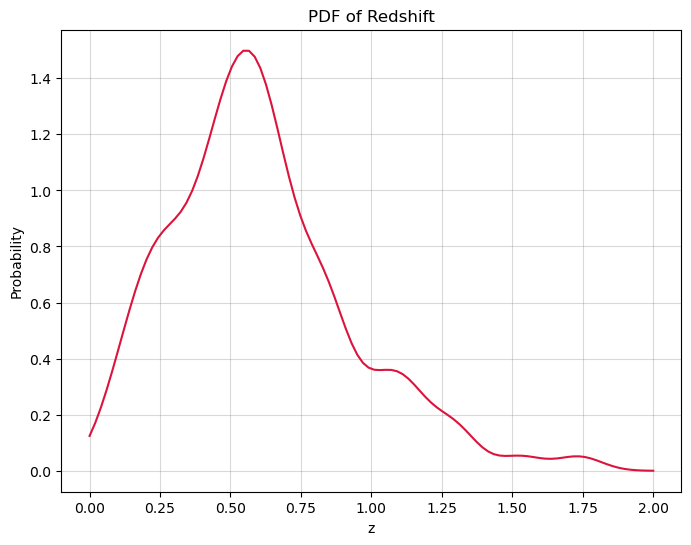

In [27]:
plt.figure(figsize=(8, 6))
pdf = KDE(z_sample_r, Xgrid, 0.08, kernel = 'gaussian')
plt.plot(Xgrid, pdf, color = 'crimson', label='Gaussian')
plt.title('PDF of Redshift')
plt.xlabel('z')
plt.ylabel('Probability')
plt.grid(alpha=0.3, c='gray')

### Cloning data (Inverse transforming sample)

Text(0, 0.5, 'z')

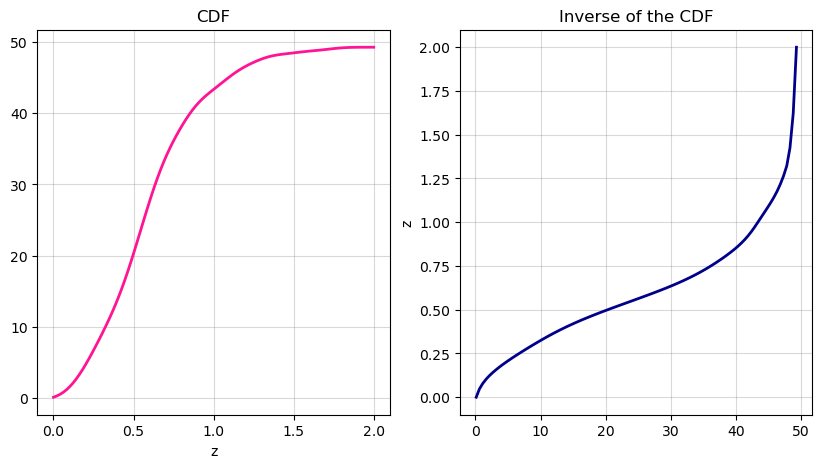

In [39]:
#I need first the cdf and then the inverse of the cdf 
cdf = np.cumsum(pdf)
inv_cdf = scipy.interpolate.interp1d(cdf, Xgrid)

#Plot them 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(Xgrid, cdf, color='deeppink', lw=2)
ax[0].grid(alpha=0.3, c='gray')
ax[0].set_title('CDF')
ax[0].set_xlabel('z')

x = np.linspace(min(cdf), max(cdf), 100)
ax[1].plot(x, inv_cdf(x), color='darkblue', lw=2)
ax[1].grid(alpha=0.3, c='gray')
ax[1].set_title('Inverse of the CDF')
ax[1].set_ylabel('z')

In [42]:
#LCDM model:
samples_LCDM = results_LCDM.samples
weights_LCDM = np.exp(results_LCDM.logwt - results_LCDM.logz[-1])  # normalized weights
samples_equal_LCDM = dyfunc.resample_equal(samples_LCDM, weights_LCDM)

random_samples_LCDM = samples_equal_LCDM[np.random.choice(len(samples_equal_LCDM),size=100)]

#Matter model:
samples_matter = results_matter.samples
weights_matter = np.exp(results_matter.logwt - results_matter.logz[-1])  # normalized weights
samples_equal_matter = dyfunc.resample_equal(samples_matter, weights_matter)

random_samples_matter = samples_equal_matter[np.random.choice(len(samples_equal_matter),size=100)]

In [66]:
#I extract point from the inverse of the cdf uniformely
points = np.random.uniform(min(cdf), max(cdf), 1000)
z_clones = inv_cdf(points)

mu_gpr = []
mu_mcmc = []
mu_nested_LCDM = []
mu_nested_matter = []

#Now I evaluate the 1000 points with the different parameters that we have found
for z in z_clones:
    #GPR
    mu_fit, sigma = gp.predict([[z]], return_std = True)
    mu_gpr.append(np.random.normal(loc = mu_fit, scale = sigma))

    #MCMC
    H0_mcmc, Om_mcmc = flat_samples[np.random.choice(flat_samples.shape[0])]
    mu_mcmc.append(LCDM1(z, H0_mcmc, Om_mcmc))
    
    #Nested samplings
    H0_LCDM, Om_LCDM = samples_equal_LCDM[np.random.choice(samples_equal_LCDM.shape[0])]
    mu_nested_LCDM.append(LCDM1(z, H0_LCDM, Om_LCDM))

    H0_matter = samples_equal_matter[np.random.choice(samples_equal_matter.shape[0])]
    H0_matter = float(H0_matter[0])
    mu_nested_matter.append(model_matter(z, H0_matter))

(30.0, 50.0)

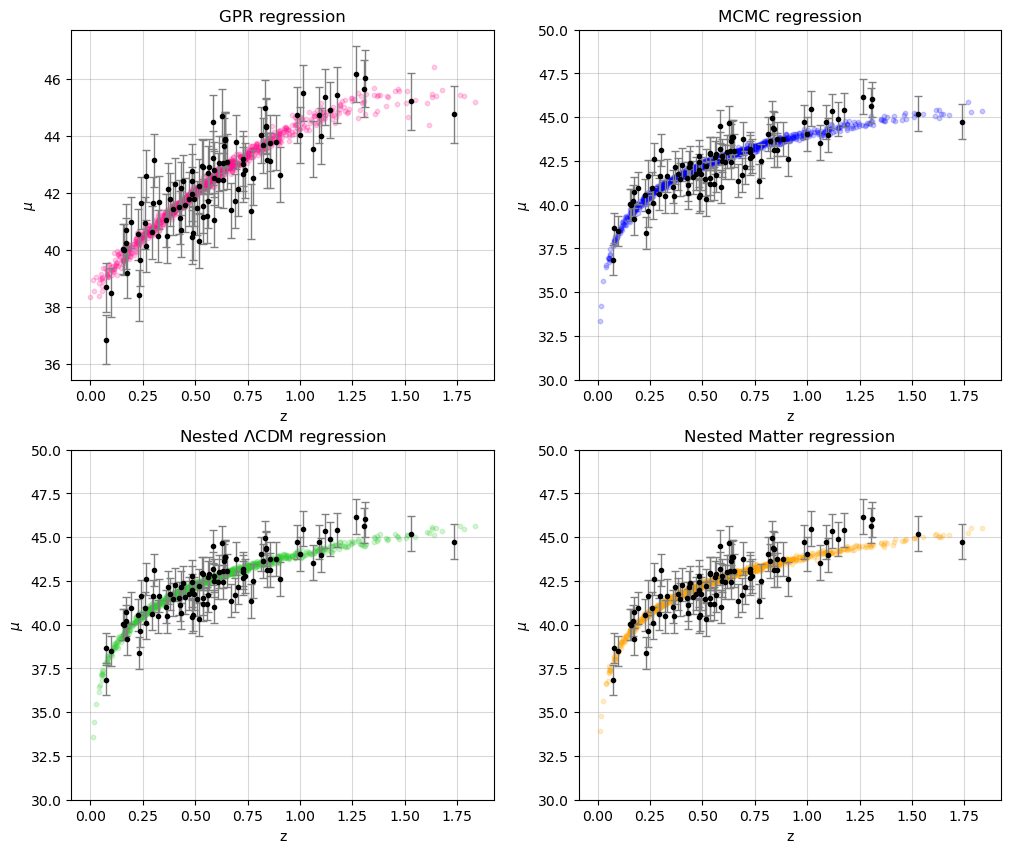

In [65]:
#Plot them
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0,0].scatter(z_clones, mu_gpr, c='deeppink', alpha = 0.2, label = 'Cloned data', s = 10)
ax[0,0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
ax[0,0].grid(alpha=0.3, c='gray')
ax[0,0].set_title('GPR regression')
ax[0,0].set_xlabel('z')
ax[0,0].set_ylabel('$\mu$')

ax[0,1].scatter(z_clones, mu_mcmc, c='blue', alpha = 0.2, label = 'Cloned data', s = 10)
ax[0,1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
ax[0,1].grid(alpha=0.3, c='gray')
ax[0,1].set_title('MCMC regression')
ax[0,1].set_xlabel('z')
ax[0,1].set_ylabel('$\mu$')
ax[0,1].set_ylim(30, 50)

ax[1,0].scatter(z_clones, mu_nested_LCDM, c='limegreen', alpha = 0.2, label = 'Cloned data', s = 10)
ax[1,0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
ax[1,0].grid(alpha=0.3, c='gray')
ax[1,0].set_title('Nested $\Lambda$CDM regression')
ax[1,0].set_xlabel('z')
ax[1,0].set_ylabel('$\mu$')
ax[1,0].set_ylim(30, 50)

ax[1,1].scatter(z_clones, mu_nested_matter, c='orange', alpha = 0.2, label = 'Cloned data', s = 10)
ax[1,1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
ax[1,1].grid(alpha=0.3, c='gray')
ax[1,1].set_title('Nested Matter regression')
ax[1,1].set_xlabel('z')
ax[1,1].set_ylabel('$\mu$')
ax[1,1].set_ylim(30, 50)